In [91]:
import numpy as np
import cv2
import heapq
import math
import time
from google.colab.patches import cv2_imshow

In [92]:
# Actions: (dx, dy) with uniform cost of 1
ACTIONS = [
    (1, 0), (-1, 0), (0, 1), (0, -1),  # Left, Right, Up, Down
    (1, 1), (-1, 1), (1, -1), (-1, -1)  # Diagonal Moves
]


In [93]:
# Define map size
WIDTH, HEIGHT = 250, 200
CLEARANCE = 2  # Clearance of 2mm around obstacles
OBSTACLE_COLOR = (0, 128, 0)  # Green
CLEARANCE_COLOR = (255, 0, 0)  # Blue
FREE_SPACE_COLOR = (255, 255, 255)  # White

In [94]:
def is_inside_E(x, y, x0=20, y0=100, width=20, height=40, mid_width=15, thickness=3):
    """
    Checks if a point (x, y) is inside the letter "E" using half-planes.
    """
    # Define the main vertical bar
    if x0 <= x <= x0 + thickness and y0 - height <= y <= y0:
        return True

    # Define the top horizontal bar
    if x0 <= x <= x0 + width and y0 - height <= y <= y0 - height + thickness:
        return True

    # Define the middle horizontal bar (shorter)
    if x0 <= x <= x0 + mid_width and y0 - height // 2 - thickness // 2 <= y <= y0 - height // 2 + thickness // 2:
        return True

    # Define the bottom horizontal bar
    if x0 <= x <= x0 + width and y0 - thickness <= y <= y0:
        return True

    return False

def is_inside_N(x, y, x0=50, y0=100, width=20, height=40, thickness=3):
    """
    Checks if a point (x, y) is inside the letter "N" using half-planes.
    """
    # Left vertical bar
    if x0 <= x <= x0 + thickness and y0 - height <= y <= y0:
        return True

    # Right vertical bar
    if x0 + width - thickness <= x <= x0 + width and y0 - height <= y <= y0:
        return True

    # Diagonal connecting top-left to bottom-right
    slope = (2/3)*height / (width - 2 * thickness)
    y_expected = (slope * (x - (x0 + thickness))) + (y0 - height)

    if x0 + thickness <= x <= x0 + width - thickness and y_expected <= y <= y_expected + height/3:
        return True

    return False




def is_inside_P(x, y, x0=80, y0=100, width=20, height=40, thickness=3, curve_radius=0):
    """
    Checks if a point (x, y) is inside the letter "P" using half-planes and a circular section.
    """
    # Left vertical bar
    if 80 <= x <= 83 and 60 <= y <= 100:
          return True

    # Approximating the curved section using a bounding box (semi-circle)
    curve_x_center = 83
    curve_y_center = 70  # Approximate center of the curve
    curve_radius = 10
    # Circular region approximation for "P"
    if ((x - 83) ** 2 + (y - 70) ** 2) <= 10 ** 2 and y < 80 and x> 83:
        return True

    return False

def is_inside_M(x, y, x0=100, y0=100, width=30, height=40, thickness=3):
    """
    Checks if a point (x, y) is inside the letter "M" using half-planes, matching the given shape.
    """
    # Left vertical bar
    if 100 <= x <= x0 + thickness and y0 - height <= y <= y0:
        return True

    # Right vertical bar
    if x0 + width - thickness <= x <= x0 + width and y0 - height <= y <= y0:
        return True

    # Left diagonal (bottom-left to middle-bottom)
    slope_left = (height / 2) / (width / 2 - thickness)
    y_expected_left = slope_left * (x - x0 - thickness) + (y0 - height)

    if x0 + thickness <= x <= x0 + width / 2 and y_expected_left  <= y <= y_expected_left + 10:
        return True

    # Right diagonal (middle-bottom to bottom-right)
    slope_right = (-height / 2) / (width / 2 - thickness)
    y_expected_right = slope_right * (x - (x0 + width / 2)) + (y0 - height / 2)

    if x0 + width / 2 <= x <= x0 + width - thickness and y_expected_right <= y <= y_expected_right + 10:
        return True

    return False

def is_inside_1(x, y, x0=210, y0=100, width=10, height=40, thickness=3):
    """
    Checks if a point (x, y) is inside the number "1" using half-planes.
    """
    # Vertical bar of "1"
    if x0 <= x <= x0 + thickness and y0 - height <= y <= y0:
        return True

    return False


def is_inside_second_6(x, y, x0=175, y0=100, large_radius=20, medium_radius=13, small_radius=8, hole_radius=5, thickness=3):
  top_x = x0 + 15 // 2  # Center slightly right
  top_y = y0 - 20 * 1.5  # Positioned higher
  inside_top = ((x - top_x) ** 2 + (y - top_y) ** 2) <= small_radius ** 2 and x >= top_x

  mid_x = x0 + large_radius - thickness  # Positioned right
  mid_y = y0 - large_radius  # Centered in middle
  inside_middle = ((x - mid_x) ** 2 + (y - mid_y) ** 2) <= large_radius ** 2 and x <= mid_x

  bottom_x = x0 + medium_radius  # Center slightly right
  bottom_y = y0 - medium_radius  # Centered lower
  inside_bottom = ((x - bottom_x) ** 2 + (y - bottom_y) ** 2) <= medium_radius ** 2 and x >= bottom_x + thickness

  hole_x = x0 + medium_radius  # Centered horizontally
  hole_y = y0 - medium_radius  # Centered vertically
  inside_hole = ((x - hole_x) ** 2 + (y - hole_y) ** 2) <= hole_radius ** 2  # Inside hole

  if (inside_top or inside_middle or inside_bottom):
    return True

  return False

def is_inside_first_6(x, y, x0=140, y0=100, large_radius=20, medium_radius=13, small_radius=8, hole_radius=5, thickness=3):
    """
    Checks if a point (x, y) is inside the number "6" using a series of connected semi-circles
    with correct radius proportions and a small hole in the center.
    """
    top_x = x0 + 15 // 2  # Center slightly right
    top_y = y0 - 20 * 1.5  # Positioned higher
    inside_top = ((x - top_x) ** 2 + (y - top_y) ** 2) <= small_radius ** 2 and x >= top_x

    mid_x = x0 + large_radius - thickness  # Positioned right
    mid_y = y0 - large_radius  # Centered in middle
    inside_middle = ((x - mid_x) ** 2 + (y - mid_y) ** 2) <= large_radius ** 2 and x <= mid_x

    bottom_x = x0 + medium_radius  # Center slightly right
    bottom_y = y0 - medium_radius  # Centered lower
    inside_bottom = ((x - bottom_x) ** 2 + (y - bottom_y) ** 2) <= medium_radius ** 2 and x >= bottom_x + thickness

    hole_x = x0 + medium_radius  # Centered horizontally
    hole_y = y0 - medium_radius  # Centered vertically
    inside_hole = ((x - hole_x) ** 2 + (y - hole_y) ** 2) <= hole_radius ** 2  # Inside hole

    if (inside_top or inside_middle or inside_bottom):
      return True

    return False

# Function for treating clearance (expanding obstacles by `CLEARANCE` pixels)
def is_inside_clearance(x, y, clearance=CLEARANCE):
    # Check if the point is near any obstacle
    for func in [is_inside_1, is_inside_second_6, is_inside_first_6, is_inside_M, is_inside_N, is_inside_P, is_inside_E]:
        if (func(x, y) or func(x - clearance, y) or func(x + clearance, y) or
            func(x, y - clearance) or func(x, y + clearance)):
            return True

    # Add clearance to the walls of the grid
    if (x <= clearance or x >= WIDTH - clearance or
        y <= clearance or y >= HEIGHT - clearance):
        return True  # Mark as obstacle due to proximity to wall

    return False

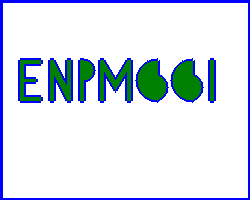

In [95]:
def create_map():
    """Create a 2D numpy grid representing the map."""
    grid = np.zeros((HEIGHT, WIDTH, 3), dtype=np.uint8)  # Create blank image (RGB)

    # Iterate through each pixel and assign colors
    for y in range(HEIGHT):
        for x in range(WIDTH):
            #HEIGHT - y - 1
            # if is_inside_E(x,y) or is_inside_N(x,y) or is_inside_P(x,y):
            #     grid[y, x] = OBSTACLE_COLOR  # Red for obstacles
            if is_inside_1(x,y) or is_inside_first_6(x,y) or is_inside_second_6(x,y) or is_inside_M(x,y) or is_inside_N(x,y) or is_inside_P(x,y) or is_inside_E(x,y):
                # print("its going inside if")
                grid[y, x] = OBSTACLE_COLOR  # Red for obstacles
            elif is_inside_clearance(x, y):
                grid[y, x] = CLEARANCE_COLOR  # Blue for clearance area
            else:
                # print("its going inside else")
                grid[y, x] = FREE_SPACE_COLOR  # White for free space

    return grid

# Create and display the map
grid = create_map()
cv2_imshow(grid)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [96]:
def within_obstacle(x, y, grid):
    """
    Check if a sampled node (x, y) lies within an obstacle or clearance area.

    Args:
        x (int): X-coordinate of the node.
        y (int): Y-coordinate of the node.
        grid (numpy.ndarray): The grid representation of the map.

    Returns:
        bool: True if the node is inside an obstacle or clearance, False otherwise.
    """

    # Get the pixel value at the given coordinates
    pixel = grid[y, x]  # (row = y, column = x)

    # Colors to avoid:
    OBSTACLE_COLOR = [0, 0, 255]   # Red (Obstacle)
    CLEARANCE_COLOR = [255, 0, 0]  # Blue (Clearance)

    if (pixel == OBSTACLE_COLOR).all() or (pixel == CLEARANCE_COLOR).all():
        return True  # Node is inside an obstacle or clearance area

    return False  # Node is in free space


In [97]:
def is_valid(x, y, grid):
    """Check if the point is within free space."""
    height, width, _ = grid.shape
    if x < 0 or x >= width or y < 0 or y >= height or within_obstacle(x,y,grid):
        return False  # Out of bounds
    return np.array_equal(grid[y, x], [255, 255, 255])  # True if white (free space)


In [98]:
from collections import deque

def bfs(grid, start, goal):
    """Breadth-First Search to find the shortest path from start to goal."""
    height, width, _ = grid.shape
    visited = set()
    queue = deque()

    # Parent dictionary for backtracking
    parent_map = {start: None}

    # Initialize BFS queue with the start node
    queue.append(start)
    visited.add(start)

    explored_nodes = []  # Store explored nodes for visualization

    while queue:
        x, y = queue.popleft()  # FIFO queue

        # If goal is reached, stop the search
        if (x, y) == goal:
            print("Goal Reached!")
            return parent_map, explored_nodes

        explored_nodes.append((x, y))

        # Explore neighbors
        for dx, dy in ACTIONS:
            nx, ny = x + dx, y + dy

            if is_valid(nx, ny, grid) and (nx, ny) not in visited:
                visited.add((nx, ny))
                parent_map[(nx, ny)] = (x, y)
                queue.append((nx, ny))

    print("No Path Found!")
    return None, None



In [99]:
def backtrack_path(parent_map, start, goal):
    """Backtracks from goal to start to get the optimal path."""
    path = []
    current = goal

    while current is not None:
        path.append(current)
        current = parent_map.get(current)

    return path[::-1]  # Reverse the path (start to goal)


In [100]:
def visualize(grid, explored_nodes, path, output_file="output.mp4"):
    """Visualizes the explored nodes and optimal path, then saves as a video."""
    height, width, _ = grid.shape
    fps = 30
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_file, fourcc, fps, (width, height))

    # Convert to BGR for OpenCV
    canvas = grid.copy()

    # Show explored nodes first
    for (x, y) in explored_nodes:
        canvas[y, x] = (200, 200, 200)  # Light Gray
        out.write(canvas)
        # cv2_imshow(canvas)
        cv2.waitKey(1)

    # Show the optimal path
    for (x, y) in path:
        canvas[y, x] = (0, 0, 255)  # Red for path
        out.write(canvas)
        # cv2_imshow(canvas)
        cv2.waitKey(1)

    out.release()
    cv2.destroyAllWindows()
    print(f"Animation saved as {output_file}")


In [101]:
# Create the map with obstacles and clearance
grid = create_map()
map_height = grid.shape[0]  # Total number of rows (height of the map)

def convert_to_grid_coordinates(x, y):
    """Convert bottom-left (x, y) to NumPy's top-left indexing."""
    return x, (map_height - 1) - y  # Invert y-coordinate

# Function to get valid user input for start and goal nodes
def get_valid_coordinates(prompt):
    while True:
        try:
            x, y = map(int, input(prompt).split())
            x, y = convert_to_grid_coordinates(x, y)  # Convert to NumPy format
            if is_valid(x, y, grid):
                return (x, y)
            else:
                print("Error: The point is inside an obstacle or out of bounds. Try again.")
        except ValueError:
            print("Invalid input! Please enter two integers separated by a space.")

# Get user input for start and goal coordinates
print("Enter Start and Goal coordinates (x y) w.r.t. bottom-left origin (in mm):")
start = get_valid_coordinates("Enter start (x y): ")
goal = get_valid_coordinates("Enter goal (x y): ")

# Run BFS algorithm
parent_map, explored_nodes = bfs(grid, start, goal)

# Backtrack and visualize optimal path
if parent_map:
    path = backtrack_path(parent_map, start, goal)
    print("the path is",path)
    visualize(grid, explored_nodes, path)
else:
    print("No valid path found!")


Enter Start and Goal coordinates (x y) w.r.t. bottom-left origin (in mm):
Enter start (x y): 3 3
Enter goal (x y): 240 190
Goal Reached!
the path is [(3, 196), (4, 196), (5, 196), (6, 196), (7, 196), (8, 196), (9, 196), (10, 196), (11, 196), (12, 196), (13, 196), (14, 196), (15, 196), (16, 196), (17, 196), (18, 196), (19, 196), (20, 196), (21, 196), (22, 196), (23, 196), (24, 196), (25, 196), (26, 196), (27, 196), (28, 196), (29, 196), (30, 196), (31, 196), (32, 196), (33, 196), (34, 196), (35, 196), (36, 196), (37, 196), (38, 196), (39, 196), (40, 196), (41, 196), (42, 196), (43, 196), (44, 196), (45, 196), (46, 196), (47, 196), (48, 196), (49, 196), (50, 196), (51, 196), (52, 196), (53, 196), (54, 196), (55, 196), (56, 196), (57, 196), (58, 196), (59, 196), (60, 196), (61, 196), (62, 196), (63, 196), (64, 196), (65, 196), (66, 195), (67, 194), (68, 193), (69, 192), (70, 191), (71, 190), (72, 189), (73, 188), (74, 187), (75, 186), (76, 185), (77, 184), (78, 183), (79, 182), (80, 181),